<a href="https://colab.research.google.com/github/tuftsdatalab/segment-anything-geo/blob/main/Segmenting_Imagery_with_Segement_Anything_Model_(SAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

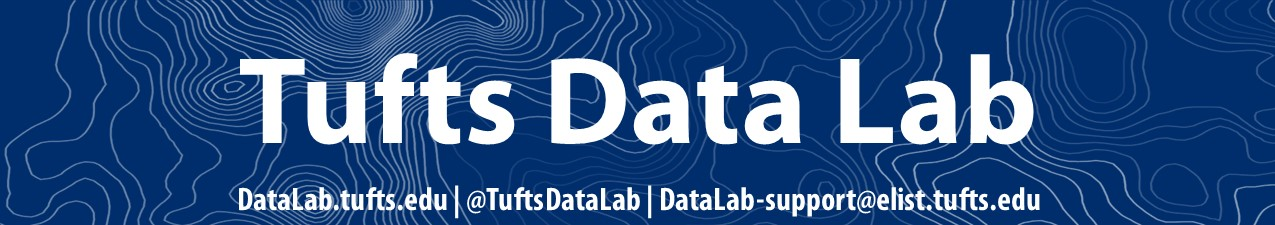

# **Segmentation and Object Identification with Text Prompts - Identifying Geese in Drone Imagery of Paradise Pond**

Written by Chad Fisher 2/25/25

This is a Tufts University Data Lab geospatial notebook based tutorial. Use it directly in Google Colab using your Google Account as you are now. You have to make a copy of it to save your work. To make a copy, click on:  ```File -> Save a Copy in Drive ```

## Introduction

In this tutorial, we will use drone imagery collected in the morning and afternoon of geese on Paradise Pond at Smith College to explore the capabilities of an image segmentation foundation model from Meta AI called [*Segment Anything Model (SAM)*](https://ai.meta.com/blog/segment-anything-foundation-model-image-segmentation/).

**Segmentation** is a core task in computer vision and is the identification of distinct objects and the classification of image pixels to these unique objects. Creating an accurate model for specific tasks typically requires extensive technical expertise, complex infrastructure, and large datasets. SAM aims to create a *foundation model*, which means a model that is generally applicable to many different tasks and comes pre-trained.

Using the [**segment-geospatial**](https://www.google.com/url?q=https%3A%2F%2Fsamgeo.gishub.org%2F) python package, we will learn to:
1. Initialize the model to use various text prompts to identify objects in a drone image
2. Compare the effects of illumination and lighting in a drone image on segmentation accuracy
3. Fine-tune model paramaters including the text threshold and box threshold.


## 1. Change the runtime and install dependencies

Image segmentation tasks can be computationally intensive and are often sped up by the use of a *GPU (graphical processing unit)* which is uniquely suited for these tasks.



0. Make a copy of this notebook in your Google Drive. Click on:  ```File -> Save a Copy in Drive ```

1. Change the runtime to the **T4 GPU** in the top right corner of Google Colab.

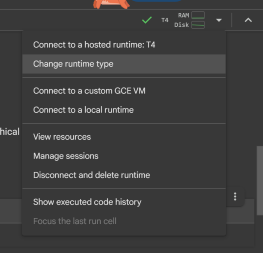

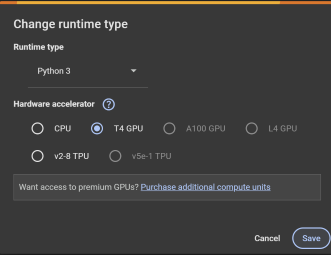



---


**Note: during this lab, you might get a warning that you are connected to GPU runtime but not using. This is OK; we have not gotten to the image processing yet! You can ignore it**

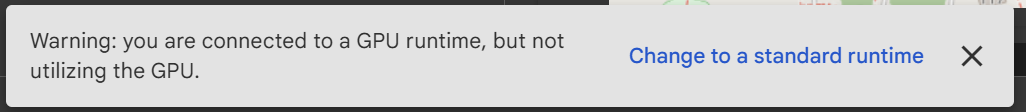


---



2. Your runtime should now look like this:

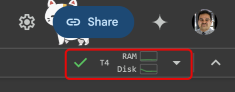

3. Uncomment (remove the # at the beginning) and run the following cell to install the required dependencies. ***This might take a while (~6 mins) so be patient :) and consider reading up on the model with the links in the introduction.***

*Note: if you see a warning that says 'This Notebook was not authored by Google,' click Run Anyway*


In [ ]:
# %pip install segment-geospatial groundingdino-py leafmap localtileserver --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.5 MB/s eta 0:00:00


4. When the installation completes, you will have to restart the runtime. Click accept on the popup that appears. Don't worry, we haven't created any variables so nothing will get deleted!

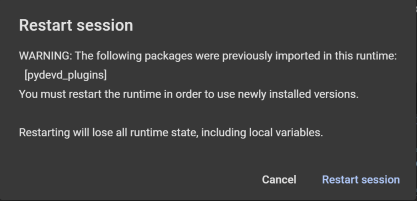

5. Enable third party Jupyter widgets (like leafmap)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

6. Now import the packages:

In [ ]:
import leafmap.foliumap as leafmap # This is an interactive mapping widget for python
from samgeo import tms_to_geotiff, split_raster # These are the functions for downloading satellite imagery and tiling data
from samgeo.text_sam import LangSAM # This is the function for initializing the model

## 2. Download Drone Imagery

1. We will be using 2 previously collected drone images of Paradise Pond that can be downloaded from Box.

In [ ]:
import urllib.request # Library for downloading data from URLs

morning_URL='https://tufts.box.com/shared/static/y072z4q64pitivzwb9sep5dibg5lolgc.tif'
urllib.request.urlretrieve(morning_URL, "morning.tif") #Download image as morning.tif

afternoon_URL='https://tufts.box.com/shared/static/8vxnxbuizhyc0idl2rb15b85b6x4el2q.tif'
urllib.request.urlretrieve(afternoon_URL, "afternoon.tif") #Download image as afternoon.tif

2.  **We've already calculated pyramids so the display is faster.** This means the display resolution will be lower when we are more zoomed out. This is the code that would have been used to create pyramids. Unlike in ArcGIS Pro, pyramids in RasterIO are stored internally (in the same file) and don't include a .ovr file.

In [ ]:
# Create pyramids so display is faster

#import rasterio
#from rasterio.enums import Resampling

#factors = [2, 4, 8, 16]

#dst = rasterio.open('morning.tif', 'r+')
#dst.build_overviews(factors, Resampling.average)
#dst.update_tags(ns='rio_overview', resampling='average')
#dst.close()

#dst = rasterio.open('afternoon.tif', 'r+')
#dst.build_overviews(factors, Resampling.average)
#dst.update_tags(ns='rio_overview', resampling='average')
#dst.close()

3. Create a new interactive map centered on our new imagery at 42.318058 N, 72.641808 W. These are the coordinates of Paradise Pond!

In [ ]:
m = leafmap.Map(center=[42.318058, -72.641808], zoom=18, height="800px")
m.add_basemap("ROADMAP")
m

4. Add the downloaded image and explore it in the widget. What do you notice? How many geese do you see? What other things might get confused for geese? Is there a particular region that has the most geese?

In [ ]:
m.layers[-1].visible = False
m.add_raster('morning.tif', layer_name="Image")
m

There are so many!

## 3. Initialize the Default Model on the Morning Image

We will now initialize the SAM model on our morning image with the default settings and try a few different text prompts including geese, bird, waterfowl, and duck.

1. Initialize the model with the following code. This also might take a while, but will only need to be done once! The initialization downloads the model weights and sets up the model for inference.

In [ ]:
sam = LangSAM()

2. Specify text prompts:

In [ ]:
P1 = "geese"
P2 = 'goose'
P3 = 'bird'
P4 = 'waterfowl'
P5 = 'duck'
P6 = 'skyscraper' #choose your own text prompt that is not in the image (i.e., skyscraper)

3. We need to tile the image so it doesn't crash the runtime (by taking up too much RAM). Run the following code to generate morning tiles. We can reuse these throughout the tutorial:

In [ ]:
split_raster('morning.tif', out_dir="morning_tiles", tile_size=(2000, 2000), overlap=0)

**Aside: what is a tile?**

Tiles are portions of the image that are used to improve processing by only looking at a small portion at a time. You can see how the tiling scheme was applied to the image below. Basically, the ``split_raster`` function starts in the top right and applies a grid with 0 overlap to make the tiles. We will work with a single tile throughout the tutorial to make things quick and limit our memory usage!

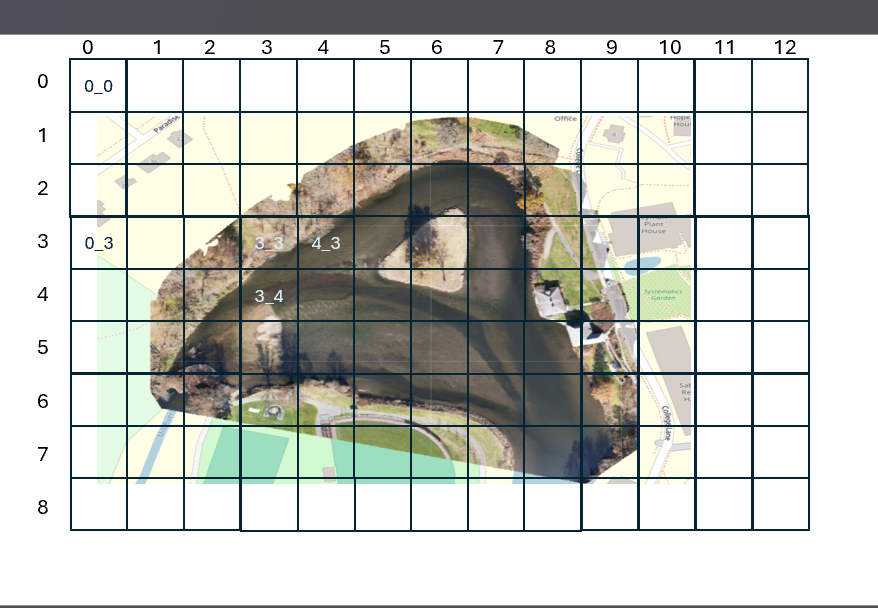

4. Segment the **tile_3_4** with the default thresholds. This tile is the 6th tile from the top and 6th from the left of the image.

In [ ]:
sam.predict(image="morning_tiles/tile_3_4.tif",
            text_prompt=P1,
            box_threshold=0.25,
            text_threshold=0.25)
sam.show_anns(
    cmap="Oranges",
    box_color="red",
    title="Automatic Segmentation of "+P1,
    blend=True
)

5. To take our results and count the number of objects, here is a function that generates a binary raster of the results, vectorize it, reads it in geopandas, and generates a count. It is based off this [example](https://samgeo.gishub.org/examples/text_prompts/). You don't need to fully understand the inner workings of this function, but will use it throughout the tutorial!

In [ ]:
import geopandas as gpd
def count_objects(text_prompt):
  sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of "+text_prompt,
    blend=False,
    output=text_prompt+".tif",
    )
  try:
    sam.raster_to_vector(text_prompt+".tif", text_prompt+".shp")
    output_counts=gpd.read_file(text_prompt+".shp").geometry.count()
  except:
    output_counts=0
  print("There are "+str(output_counts)+" "+text_prompt+" in this image.")

In [ ]:
#Test the function on the segmentation you just ran!

sam.predict(image="morning_tiles/tile_3_4.tif",
            text_prompt=P1,
            box_threshold=0.25,
            text_threshold=0.25)
count_objects(P1)

6. Now segment with each of the 4 other text prompts (P2 - P5) and one of your own that you determined in step 2.

In [ ]:
for prompt in [P1, P2, P3, P4, P5, P6]:
  sam.predict(image="morning_tiles/tile_3_4.tif",
              text_prompt=prompt,
              box_threshold=0.25,
              text_threshold=0.25)
  sam.show_anns(cmap="Oranges",
                box_color="red",
                title="Automatic Segmentation of "+prompt,
                blend=True)
  count_objects(prompt)

7. Compare each of the results for the different text prompts. Which prompt was most effective? Why do you think the results are the way they are? What other prompts might you want to try?

8. Select a different tile and determine the best text prompt for the default thresholds:

In [ ]:
my_best_prompt='' #Put your best prompt here

sam.predict(image="morning_tiles/tile_X_X.tif", #Replace the X_X with your tile number
            text_prompt=my_best_prompt,
            box_threshold=0.25,
            text_threshold=0.25)
sam.show_anns(cmap="Oranges",
              box_color="red",
              title="My best segmentation prompt (default thresholds): "+my_best_prompt,
              blend=True)
count_objects(my_best_prompt)

9. Right-click on the image and save your results!

## Interactive Segmentation

You can also do segmentation interactively on a tile and can adjust text prompts, box thresholds, and text thresholds.

```text_prompt```: the prompt that is supplied to the model.

```box_threshold```: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

```text_threshold```: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

**Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision (how many of the classified objects are actually those objects) or recall (how many objects that are actually the object are classified correctly).**

You can read more about different types of accuracy here: https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

1. Turn on interactive segmentation

In [ ]:
#First do one manually to get things set up:
sam.predict(image="morning_tiles/tile_6_6.tif",
            text_prompt='bird',
            box_threshold=0.25,
            text_threshold=0.25)

#Then show map
sam.show_map()

2. Choose one text prompt and adjust the box and text threshold above. Click **Segment** to update the visualization on the map. You can also adjust the opacity and color of the results. **How does changing these thresholds effect your results?**

3. Once you are happy with your results, generate an image showing your results below and include your thresholds:

In [ ]:
my_best_prompt='' #Put your best prompt here

sam.predict(image="morning_tiles/tile_6_6.tif",
            text_prompt=my_best_prompt,
            box_threshold=??, #Put your value here
            text_threshold=??) #and here
sam.show_anns(cmap="Oranges",
              box_color="red",
              title="Tile 6_6 (box_threshold=XX, text_threshold=XX): "+my_best_prompt,
              blend=True)
count_objects(my_best_prompt)

4. Save the image to submit with your report:

## Effects of Illumination: Afternoon Image

Now we are going to compare these results to an afternoon image of the same location.

1. Compare the afternoon imagery to the morning imagery. What do you notice is different? Do you think it'll be easier or harder to identify the geese in this image? How might this affect your threshold values?:

In [ ]:
m = leafmap.Map(center=[42.318058, -72.641808], zoom=18, height="800px")
m.add_basemap("ROADMAP")
m.split_map(
    left_layer="morning.tif",
    right_layer="afternoon.tif",
)
m

1. First generate tiles for the afternoon image.

In [ ]:
split_raster('afternoon.tif', out_dir="afternoon_tiles", tile_size=(2000, 2000), overlap=0)

2. Let's compare segmentation models. First run the model on tile 5_6 with 'bird' and the default thresholds. Then run the same thing but on the afternoon tile.

In [ ]:
sam.predict(image="morning_tiles/tile_5_5.tif",
            text_prompt='bird',
            box_threshold=0.25,
            text_threshold=0.25)
sam.show_anns(cmap="Oranges",
              box_color="red",
              title="Morning tile 5_6 (defaults): geese",
              blend=True)
count_objects('bird')

In [ ]:
sam.predict(image="afternoon_tiles/tile_5_5.tif",
            text_prompt='bird',
            box_threshold=0.25,
            text_threshold=0.25)
sam.show_anns(cmap="Oranges",
              box_color="red",
              title="Afternoon tile 5_6 (defaults): geese",
              blend=True)
count_objects('bird')

3. Because of the different illumination, we need to lower the box_threshold.

In [ ]:
sam.predict(image="afternoon_tiles/tile_5_5.tif",
            text_prompt='bird',
            box_threshold=0.2,
            text_threshold=0.25)
sam.show_anns(cmap="Oranges",
              box_color="red",
              title="Afternoon tile 5_6 (defaults): geese",
              blend=True)
count_objects('bird')

# Conclusion

In this tutorial, we scratched the surface of tiling drone imagery for use in a segmentation mode. We saw how different text prompts can affect results, how illumination might affect segmentation accuracy or require us to adjust model paramaters, and how to interactively test segmentation with a sandbox map.